In [16]:
from serial import Serial
import hvplot.streamz
from streamz.dataframe import DataFrame
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# https://hvplot.holoviz.org/user_guide/Streaming.html
cols = ['t','x','y','z']
df_example = pd.DataFrame(columns=cols)
df = DataFrame(example=df_example)

In [3]:
#Connect the Arduino Nano 33 IoT to your computer.  
port = Serial(port="/dev/cu.usbmodem14201", baudrate=115200)
port.flushInput()
# Possible errors: 
# "Resource busy": close the serial window in the Arduino IDE and try again

In [4]:
#This way will plot as a smooth line
df.hvplot(x='t', backlog=50, kind='line')

# This way will plot each sample as a dot and then connect them with a line.  It's a bit slower?
#df.hvplot(x='t', backlog=50, kind='scatter') * df.hvplot(x='t', backlog=50, kind='line')
# re-run this cell to clear the graph

:DynamicMap   []
   :NdOverlay   [Variable]
      :Curve   [t]   (value)

In [5]:
#start_time = dt.timestamp(dt.now())

# Experiment 1: Orientation (3 axes)

In [ ]:
#for i in range(30): # Option 2: read 30 samples and then stop
while(True): #Option 1: stream forever.  must use "Kernel" --> "Interrupt" to stop
    try:
        line = port.readline().decode("utf-8")
        t, x, y, z = [float(axis) for axis in line.strip().split("\t")]
        #t= dt.timestamp(dt.now()) - start_time
        # print("t={0} x={1} y={2} z={3}".format(t,x,y,z))
        df.emit(pd.DataFrame([[t,x,y,z]], columns=cols))
        #TODO: speed things up by reading out 1s of samples (5-10?) and emitting them all at once
    except Exception as err:
        #skip over the header lines
        print("Could not parse line: " + line)
        print(err)

In [ ]:
# do some buffering
buffer_size = 4 # update every 0.5 seconds 
while(True): #stream forever.  must use "Kernel" --> "Interrupt" to stop
    try:
        df_buffer = pd.DataFrame(columns=cols)
        for i in range(buffer_size):
            line = port.readline().decode("utf-8")
            t, x, y, z = [float(axis) for axis in line.strip().split("\t")]
            t = t/1000. #convert from milliseconds to seconds
            # print("t={0} x={1} y={2} z={3}".format(t,x,y,z))
            df_buffer = df_buffer.append(pd.DataFrame([[t,x,y,z]], columns=cols))
        #print(df_buffer)
        df.emit(df_buffer)
        #TODO: speed things up by reading out 1s of samples (5-10?) and emitting them all at once
    except Exception as err:
        #skip over the header lines
        print("Could not parse line: " + line)
        print(err)

# Experiment 2: Acceleration, Velocity, and position (single axis)

In [ ]:
# https://hvplot.holoviz.org/user_guide/Streaming.html
cols = ['t','x_acc','x_vel','x_pos']
df_example = pd.DataFrame(columns=cols)
df = DataFrame(example=df_example)

In [ ]:
# do some buffering
buffer_size = 4 # update every 0.5 seconds 
while(True): #stream forever.  must use "Kernel" --> "Interrupt" to stop
    try:
        df_buffer = pd.DataFrame(columns=cols)
        for i in range(buffer_size):
            line = port.readline().decode("utf-8")
            t, x, y, z = [float(axis) for axis in line.strip().split("\t")]
            t = t/1000. #convert from milliseconds to seconds
            # print("t={0} x={1} y={2} z={3}".format(t,x,y,z))
            df_buffer = df_buffer.append(pd.DataFrame([[t,x,y,z]], columns=cols))
        #print(df_buffer)
        df.emit(df_buffer)
        #TODO: speed things up by reading out 1s of samples (5-10?) and emitting them all at once
    except Exception as err:
        #skip over the header lines
        print("Could not parse line: " + line)
        print(err)

In [45]:
# First do an offline demo to explain how acceleration, velocity, and position are related
x_accel = [0, 0, 0.25, 0.5, 0.5, 0.25, 0, -0.25, -0.5, -0.5,-0.25, 0]
t = np.arange(len(x_accel))
x_vel = []
x_pos = []
# Initial conditions - optional to discuss.  The accel can only measure change in velocity, 
# but we need need to know the orignal velocity and position were to start 
x_vel.append(0) # x_vel[0]
x_pos.append(0) # x_pos[0]
x_pos.append(0) # x_pos[1]

# Velocity is the integral of acceleration (or acceleration is the derrivative (change in) of velocity)
# We "add up" the accelerometer value over time
for i in range(1, len(x_accel)):
    x_vel.append(x_accel[i] + x_vel[i-1])
    
# Position is the integral of velocity (and double integral of acceleration).  Velocity is the derrivative of position
for j in range(2, len(x_accel)):
    x_pos.append(x_vel[j]+x_pos[j-1])
    

Text(0, 0.5, 'position')

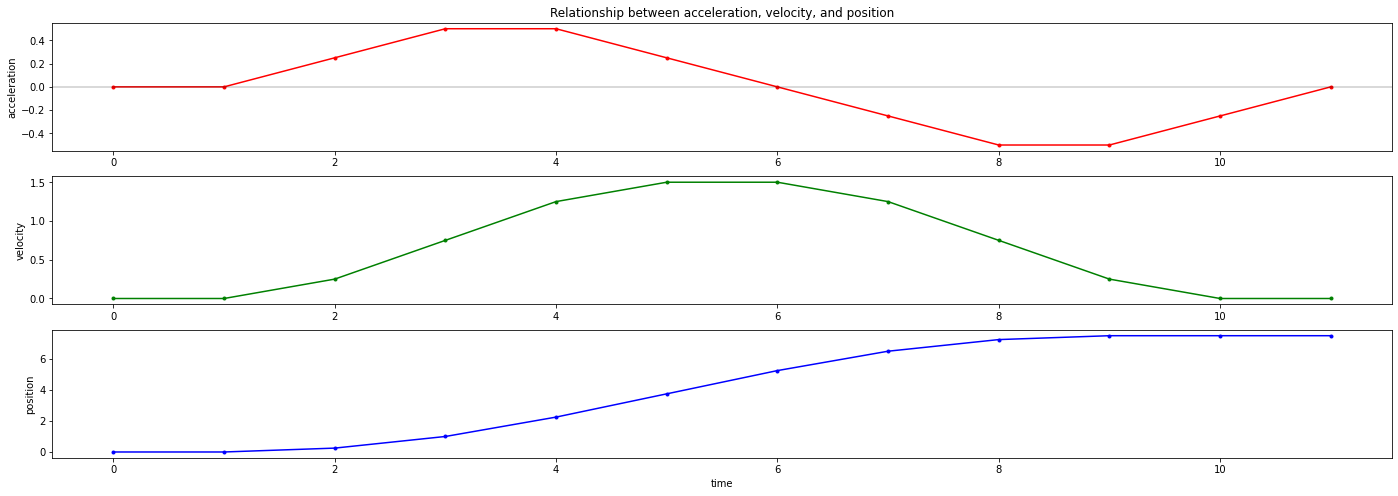

In [44]:
# Plot accel, velocity, and position to show how an accel can be used for "dead-reckoning" tracking
plt.figure(figsize=[24,8])
plt.subplot(3,1,1)
plt.plot(t, x_accel,'r.-',label='acceleration')
xlim =plt.xlim() # save the xlimits
plt.plot([t[0]-1,t[-1]+1], [x_accel[0], x_accel[-1]], 'k-', alpha=0.2) # plot zero-crossing line
plt.xlim(xlim) # restore xlim (lims auto expanded by zero-crossing line)
plt.ylabel("acceleration")
plt.title("Relationship between acceleration, velocity, and position")
plt.subplot(3,1,2)
plt.plot(t, x_vel,'g.-',label='velocity')
plt.ylabel("velocity")
plt.subplot(3,1,3)
plt.plot(t, x_pos,'b.-',label='position')
plt.xlabel('time')
plt.ylabel("position")


In [ ]:
# Now let's use these equations with our accelerometer sensor to estimate the velocity and position of an object.